In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import jax.numpy as jnp
from jax import hessian

First I create data for the 2dim poisson equation:
$$\nabla^2 u(x,t) =  \left( \frac{\partial^2 }{\partial x^2} + \frac{\partial^2 }{\partial y^2} \right) u(x,y)= \frac{\rho(x,y)}{\varepsilon}$$     
I will just use a simple $\rho(x,y)$. 

T

In [ ]:
import numpy as np

def potential_2D(x, y, charge, charge_pos):
    """
    Computes the electrostatic potential in 2D due to a point charge.
    
    Parameters:
    x: numpy.ndarray - x coordinates where the potential is computed
    y: numpy.ndarray - y coordinates where the potential is computed
    charge: float - quantity of the point charge
    charge_pos: tuple of float - coordinates of the point charge
    
    Returns:
    numpy.ndarray - the electrostatic potential
    """
    k = 1 / (2 * np.pi)  
    dx = x - charge_pos[0]
    dy = y - charge_pos[1]
    return k * charge * np.log(np.sqrt(dx**2 + dy**2))


In [20]:
@jit
def sqeuclidean_distance(x, y):
    return jnp.sum((x-y)**2)

# RBF Kernel
@jit
def rbf_kernel(x, y, params):
    return params[1]*jnp.exp( - params[0] * sqeuclidean_distance(x, y))



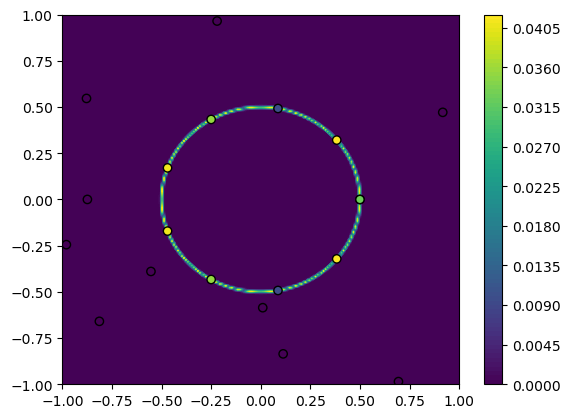

In [162]:
def multivariate_normal(x, mean, cov):
    """
    Computes the multivariate normal distribution for a given mean and covariance matrix.
    
    Parameters:
    x: numpy.ndarray - points where the distribution is evaluated
    mean: numpy.ndarray - mean of the distribution
    cov: numpy.ndarray - covariance matrix of the distribution
    
    Returns:
    numpy.ndarray - the multivariate normal distribution
    """
    k = x.shape[0]
    norm_factor = 1 / (np.sqrt((2 * np.pi)**k * np.linalg.det(cov)))
    cov_inv = np.linalg.inv(cov)
    exponent = -0.5 * (x - mean).T @ cov_inv @ (x - mean)
    return norm_factor * np.exp(exponent)

from scipy.stats import multivariate_normal

def rho(x, y, R, Q, sigma=0.003):
    # Convert to polar coordinates
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    # Total charge density of the ring
    q = Q / (2 * np.pi * R)
    # Create a grid of points
    pos = np.dstack((x, y))
    # Calculate the charge density
    rho = np.zeros_like(r)
    theta_values = np.linspace(0, 2*np.pi, int(2*np.pi*R/sigma))
    for theta_val in theta_values:
        mu = [R * np.cos(theta_val), R * np.sin(theta_val)]
        rv = multivariate_normal(mu, sigma**2)
        rho += q * rv.pdf(pos)
    return rho

x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)

# Define the radius and total charge of the ring
R = 0.5
line_charge = 10
q_single = line_charge / (2 * np.pi * R)

# Calculate the charge density
rho_values = rho(X, Y, R, q_single)
rho_values = rho_values/np.sum(rho_values) * line_charge
plt.contourf(X, Y, rho_values, 100, cmap='viridis')
def sample_rho_points(x, y, rho, R, num_samples_ring=10, num_samples_not_ring=10):
    # 1. Sample points on the ring
    ring_theta = np.linspace(0, 2*np.pi, num_samples_ring)
    ring_x = R * np.cos(ring_theta)
    ring_y = R * np.sin(ring_theta)

    # 2. Random sampling for points not on the ring
    not_ring_x = np.random.uniform(x.min(), x.max(), num_samples_not_ring)
    not_ring_y = np.random.uniform(y.min(), y.max(), num_samples_not_ring)

    # Combine all sampled points
    sample_x = np.concatenate([ring_x, not_ring_x])
    sample_y = np.concatenate([ring_y, not_ring_y])

    # Get rho at sampled points
    x_indices = [np.argmin(np.abs(x - pos)) for pos in sample_x]
    y_indices = [np.argmin(np.abs(y - pos)) for pos in sample_y]
    sampled_rho = rho[y_indices, x_indices]

    return jnp.array(sample_x), jnp.array(sample_y), jnp.array(sampled_rho)

sample_x_rho, sample_y_rho, sampled_rho = sample_rho_points(x, y, rho_values, R)

# Plot the charge density and the sampled points


# Plot the charge density and the sampled points
plt.contourf(X, Y, rho_values, 100, cmap='viridis')
plt.colorbar()
plt.scatter(sample_x_rho, sample_y_rho, c=sampled_rho, cmap='viridis', edgecolor='k')
plt.show()


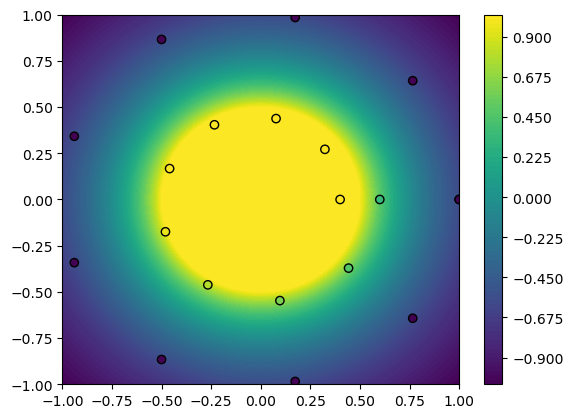

In [212]:
def calculate_potential(x,y,rho, R, line_charge):
    # Convert to polar coordinates
    r = np.sqrt(x**2 + y**2)
    #phi outiside the ring
    phi_outside = np.where(r > R, line_charge / (2 * np.pi * r), 0)
    phi_inside = np.where(r < R, line_charge / (2 * np.pi * R), 0)
    return phi_outside + phi_inside

phi_values = calculate_potential(X, Y, rho_values, R, line_charge)

def sample_points(x, y, V, R, num_samples=20):
    # Number of samples for each strategy
    num_samples_interest = num_samples // 2
    num_samples_far = num_samples // 2
    num_samples_random = num_samples - num_samples_interest - num_samples_far

    # 1. Sample points around the ring
    interest_radius = np.linspace(R-0.1, R+0.1, num_samples_interest)
    interest_theta = np.linspace(0, 2*np.pi, num_samples_interest)
    interest_x = interest_radius * np.cos(interest_theta)
    interest_y = interest_radius * np.sin(interest_theta)

    # 2. Sample points far away from the ring
    far_radius = np.linspace(R+0.5, 2*R, num_samples_far)
    far_theta = np.linspace(0, 2*np.pi, num_samples_far)
    far_x = far_radius * np.cos(far_theta)
    far_y = far_radius * np.sin(far_theta)

    # 3. Random sampling
    random_x = np.random.uniform(x.min(), x.max(), num_samples_random)
    random_y = np.random.uniform(y.min(), y.max(), num_samples_random)

    # Combine all sampled points
    sample_x = np.concatenate([interest_x, far_x, random_x])
    sample_y = np.concatenate([interest_y, far_y, random_y])

    # Get potential at sampled points
    x_indices = [np.argmin(np.abs(x - pos)) for pos in sample_x]
    y_indices = [np.argmin(np.abs(y - pos)) for pos in sample_y]
    sampled_potentials = V[y_indices, x_indices]

    return jnp.array(sample_x), jnp.array(sample_y), jnp.array(sampled_potentials)

sample_x, sample_y, sampled_potentials = sample_points(x, y, phi_values, R)
sampled_potentials = sampled_potentials-np.mean(sampled_potentials)
# Plot the potential and the sampled points
plt.contourf(X, Y, phi_values-np.mean(phi_values), 100, cmap='viridis')
plt.colorbar()
plt.scatter(sample_x, sample_y, c=sampled_potentials, cmap='viridis', edgecolor='k')
plt.show()


In [164]:
params = [1.,1.]

def laplacian_rbf_kernel(x, y, params,argument):
    return jnp.trace(hessian(rbf_kernel, argnums=(argument))(x, y,params))

@jit
def laplacian_laplacian_rbf_kernel(x, y, params):
    return jnp.trace(hessian(laplacian_rbf_kernel, argnums=(0))(x, y,params,1))
laplacian_laplacian_rbf_kernel( x, y,params)


Array(161600., dtype=float32)

In [213]:
@jit
def k_uf(x, y, params):
    return vmap(vmap( laplacian_rbf_kernel, in_axes=(None, 0, None,None)), in_axes=(0, None, None,None))(x, y, params,1)
@jit
def k_fu(x, y, params):
    return vmap(vmap( laplacian_rbf_kernel, in_axes=(0, None, None,None)), in_axes=(None, 0, None,None))(x, y, params,0)
@jit
def k_uu(x, y, params):
    return vmap(vmap( rbf_kernel, in_axes=(None, 0, None)), in_axes=(0, None, None))(x, y, params)
@jit
def k_ff(x, y, params):
    return vmap(vmap( laplacian_laplacian_rbf_kernel, in_axes=(0, None, None)), in_axes=(None, 0, None))(x, y, params)

@jit 
def block_matrix(x, y, params,noise_f = 1e-8,noise_u = 1e-8):
    return jnp.block([[k_uu(x, x, params) + noise_u*jnp.eye(len(x)), k_uf(x, y, params)], 
                      [k_fu(y, x, params),                           k_ff(y, y, params)+ noise_u*jnp.eye(len(y))]])


In [214]:
params = [0.1,0.1]
X_f = np.array([sample_x_rho,sample_y_rho]).T
X_u = np.array([sample_x,sample_y]).T
targets = np.concatenate([sampled_potentials,sampled_rho])
block_matrix(X_u, X_f, params)


Array([[ 0.10000001,  0.09920797,  0.09708542, ..., -0.02849038,
        -0.03044837, -0.02659676],
       [ 0.09920797,  0.10000001,  0.09912089, ..., -0.02921989,
        -0.03413288, -0.02913736],
       [ 0.09708542,  0.09912089,  0.10000001, ..., -0.03192069,
        -0.03714398, -0.03309456],
       ...,
       [-0.03205214, -0.02770208, -0.02509753, ...,  0.03200001,
         0.02059798,  0.02921665],
       [-0.03626591, -0.03205214, -0.02770209, ...,  0.02059798,
         0.03200001,  0.02650107],
       [-0.03803709, -0.03626591, -0.03205214, ...,  0.02921665,
         0.02650107,  0.03200001]], dtype=float32)

In [190]:
from scipy.optimize import minimize
from tqdm import tqdm

def log_marginal_likelihood(Kernel:callable, x,y,targets,hyperparams):
    
    K = Kernel(x,y,hyperparams)  + 1e-6*jnp.eye(len(x)*2) #some extra jitter
    
    L = jnp.linalg.cholesky(K)
    alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, targets))
    mll = 1/2 * jnp.dot(targets.T,alpha) +0.5*jnp.sum(jnp.log(jnp.diagonal(L))) + len(x)/2 * jnp.log(2*jnp.pi)
    return mll
test_params = [0.1,1.]
print(log_marginal_likelihood(block_matrix, X_u,X_f,targets,test_params))

def log_marginal_likelihood_to_optimize(Kernel:callable, x,y,targets):
    def function_to_optimize(hyperparams):
        mll = log_marginal_likelihood(Kernel, x,y,targets,hyperparams)
        return mll
    return function_to_optimize

def optimization_restarts(Kernel: callable,n_restarts, X, X_bar, targets):
    
    best_mll = np.inf
    best_theta = np.zeros((2))
    for i in tqdm(range(n_restarts)):
        rng = np.random.default_rng()
        l_initial = rng.uniform(4,10,1)
        sigma_initial = rng.uniform(0,1,1)
        theta_initial = np.array([l_initial,sigma_initial]).reshape(2)
        res = minimize(log_marginal_likelihood_to_optimize(Kernel, X,X_bar, targets), x0=theta_initial,
                    method='L-BFGS-B', bounds=((1e-5, None), (1e-2, None)))
        if res.fun < best_mll:
            best_mll = res.fun
            best_theta = res
    return best_theta
res = optimization_restarts(block_matrix,200, X_u,X_f,targets)
print(res)

nan


100%|██████████| 200/200 [00:09<00:00, 21.98it/s]

[0. 0.]


Array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

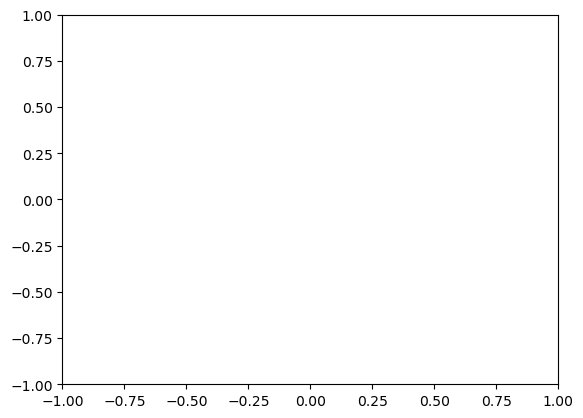

In [236]:
theta  = [0.001,0.001]
x1 = np.linspace(-1, 1, 100)
y1 = np.linspace(-1, 1, 100)
xx, yy = np.meshgrid(x1, y1)
x_star = np.array([xx.flatten(), yy.flatten()]).T


L = jnp.linalg.cholesky(block_matrix(X_u, X_f, theta))
q_1 = k_uu(x_star,X_u,theta) 
q_2 = k_uf(x_star,X_u, theta) 
q = jnp.hstack((q_1,q_2))
alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, targets))
f_star = q@alpha
f_star = f_star.reshape(100,100)
plt.contourf(xx, yy, f_star, 100, cmap='viridis')
f_star

In [7]:
from sklearn.metrics.pairwise import rbf_kernel as rbf_sklearn
def d2rbf_kernel_scratch_jac(gamma, X, Y):
    d2K_fg2_ = np.empty(X.shape[-1])
    
    constant = 2 * gamma
    
    k_val = rbf_sklearn(np.array(X), np.array(Y), gamma=gamma)
    
    for idim in range(X.shape[1]):
        
        # compute the xterm: 2 gamma (xj - yj)^2
        x_val = constant * (X[:, idim] - Y[:, idim]) ** 2 - 1

        # compute the derivative term
        d2K_fg2_[idim] = constant * x_val * k_val 
    return d2K_fg2_
d2K_fg2_ = d2rbf_kernel_scratch_jac(1., x.reshape(1,-1), y.reshape(1,-1))
print(d2K_fg2_)

[0.09433125 0.01347589]



Name : GP regression
Objective : 1.1323440074920654
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   3.518356013727809  |      +ve      |        
  rbf.lengthscale          |  1.0280476938101888  |      +ve      |        
  Gaussian_noise.variance  |               1e-06  |   +ve fixed   |        


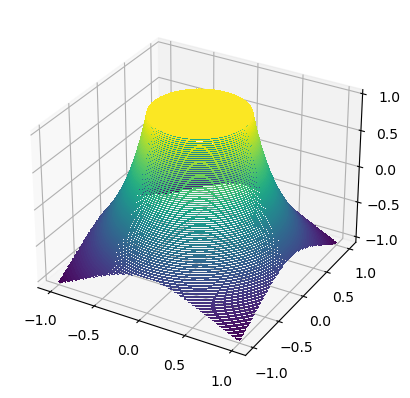

In [205]:
import GPy
kernel = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)
targets = sampled_potentials.reshape(-1,1)
X_u = np.array([sample_x,sample_y]).T
m = GPy.models.GPRegression(X_u, targets, kernel)
m.Gaussian_noise.variance.fix(1e-6)
m.optimize(messages=True)
print(m)

#make fig 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#plot = m.plot(ax=ax)
ax.contourf(X, Y, phi_values-np.mean(phi_values), 100, cmap='viridis')

In [1]:
import numpy as np
from scipy.sparse import diags
from scipy.integrate import solve_ivp

# Define the grid
x = np.linspace(0, 1, 100)  # Spatial grid
t = np.linspace(0, 1, 100)  # Temporal grid

# Define the coefficients
alpha = 1  # Thermal diffusivity

# Define the initial condition
u0 = np.zeros_like(x)

# Define the forcing term
def f(x, t):
    # Forcing term here is just a simple example. You can replace with your own function.
    return np.exp(-t)*np.sin(2*np.pi*x) *(4*np.pi**2 - 1)

# Define the finite difference operator
diagonals = [-2 * np.ones(100), np.ones(99), np.ones(99)]
laplacian = diags(diagonals, [0, -1, 1]).toarray() / (x[1] - x[0])**2

# Define the ODE system (the heat equation in this case)
def heat_eqn(t, u):
    return alpha * np.dot(laplacian, u) + f(x, t)

# Solve the ODE system
sol = solve_ivp(heat_eqn, (0, 1), u0, method='RK45', t_eval=t)
sol.y.shape

(100, 100)

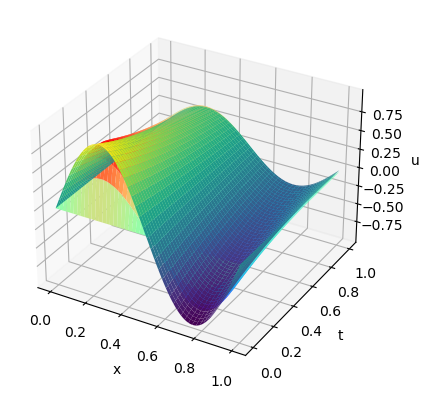

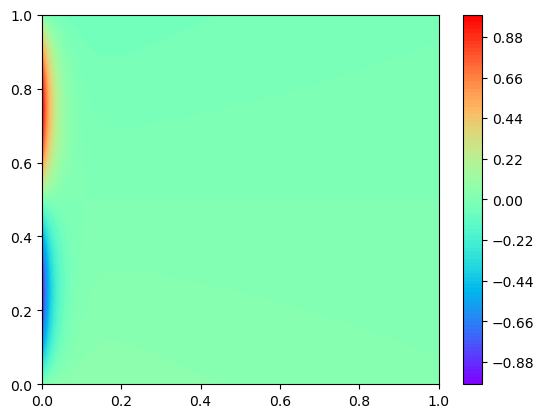

In [5]:
import matplotlib.pyplot as plt
X, T = np.meshgrid(x, t)
def f(t,x):
        return np.exp(-t)*np.sin(2*np.pi*x) *(4*np.pi**2 - 1)
def u(t,x):
    return np.exp(-t)*np.sin(2*np.pi*x)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, sol.y, cmap='rainbow')
ax.plot_surface(T, X, u(X,T), cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.show()
plt.contourf(X, T, sol.y-u(X,T), 100, cmap='rainbow')
plt.colorbar()

In [ ]:
def print():
    print("hello")
dictionari = {"a":print}
dictionari["a"]()